In [1]:
# !pip install altair
# # Install meridian: from PyPI @ latest release
# !pip install --upgrade google-meridian[colab,and-cuda]

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 25.8 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [2]:
# Connect To Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# # Assuming your CSV file is in the 'MyDrive' folder
# file_path = '/content/drive/MyDrive/mmm_train_all.csv'
# # Read the CSV file into a pandas DataFrame
# raw_data = pd.read_csv(file_path)

In [4]:
# Assuming your CSV file is in the 'MyDrive' folder
#file_path = '/content/drive/MyDrive/mmm_train_all.csv'
file_path = 'mmm_train_all.csv'
# Read the CSV file into a pandas DataFrame
raw_data = pd.read_csv(file_path)

In [5]:
raw_data.shape

(335, 30)

In [6]:
raw_data = raw_data.drop_duplicates()
raw_data.shape

(335, 30)

In [7]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'podcast_streams', 'linkedin_spend',
       'linkedin_impressions', 'linkedin_clicks', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend', 'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'mql_count',
       'impactDotCom_ga4_sessions', 'month', 'daily_avg_queries',
       'inflation_rate', 'date_y', 'durable_goods_rates', 'averageMQL',
       'smoothed_MQL'],
      dtype='object')

# Raw Data Import

In [8]:
# Assuming your DataFrame has a date column called 'date'
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [Unnamed: 0, model_week, date, iso_week, iso_year, ga4_sessions, podcast_streams, linkedin_spend, linkedin_impressions, linkedin_clicks, gSearch_sessions, gSearch_impressions, gift_spend, email_opened_cnt, direct_spend, fb_spend, fb_impressions, fb_clicks, googleAds_spend, googleAds_impressions, event_spend, mql_count, impactDotCom_ga4_sessions, month, daily_avg_queries, inflation_rate, date_y, durable_goods_rates, averageMQL, smoothed_MQL, date_diff]
Index: []

[0 rows x 31 columns]


In [10]:
data = raw_data[['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions',
        'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend','googleAds_spend','event_spend', 'mql_count',
       'impactDotCom_ga4_sessions',  'daily_avg_queries', 'smoothed_MQL',  'daily_avg_queries',
       'inflation_rate','durable_goods_rates']].copy()
data['mql_count'] = data['mql_count'].fillna(0)
data['smoothed_MQL'] = data['smoothed_MQL'].fillna(0)
data['revenueProxy'] = data['smoothed_MQL'] * 1000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       335 non-null    object 
 1   podcast_streams            335 non-null    float64
 2   linkedin_spend             335 non-null    float64
 3   gSearch_sessions           335 non-null    float64
 4   gift_spend                 335 non-null    float64
 5   email_opened_cnt           335 non-null    float64
 6   direct_spend               335 non-null    float64
 7   fb_spend                   335 non-null    float64
 8   googleAds_spend            335 non-null    float64
 9   event_spend                335 non-null    float64
 10  mql_count                  335 non-null    int64  
 11  impactDotCom_ga4_sessions  335 non-null    float64
 12  daily_avg_queries          335 non-null    float64
 13  smoothed_MQL               335 non-null    float64

In [12]:
# Assuming your DataFrame has a date column called 'date'
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [date, podcast_streams, linkedin_spend, gSearch_sessions, gift_spend, email_opened_cnt, direct_spend, fb_spend, googleAds_spend, event_spend, mql_count, impactDotCom_ga4_sessions, daily_avg_queries, smoothed_MQL, daily_avg_queries, inflation_rate, durable_goods_rates, revenueProxy, date_diff]
Index: []


In [13]:
# Data Load

In [14]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
# data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# # Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# # Identify the output (revenue) column(s)
# output = [
#     col for col in data.columns
#     if 'revenue' in col.lower()
# ]

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenueproxy' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,mql_count,impactDotCom_ga4_sessions,daily_avg_queries,smoothed_MQL,daily_avg_queries,inflation_rate,durable_goods_rates,revenueProxy,date_week,t
0,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,9000.0,2169.57,6448.16,0.0,61,5091.0,24779.0,61.0,24779.0,0.0336,0.0022,61000.0,2024-04-11,0
1,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,0.0,60,4936.0,24779.0,60.0,24779.0,0.0336,0.0022,60000.0,2024-04-12,1
2,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,0.0,21,2708.0,24779.0,21.0,24779.0,0.0336,0.0022,21000.0,2024-04-13,2
3,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,0.0,30,2665.0,24779.0,30.0,24779.0,0.0336,0.0022,30000.0,2024-04-14,3
4,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,0.0,116,7681.0,24779.0,116.0,24779.0,0.0336,0.0022,116000.0,2024-04-15,4


# Collinearity

******** Spend Share Analysis ********
     Media_Channel  Spend_Share
0   linkedin_spend     0.510996
1       gift_spend     0.011892
2     direct_spend     0.142351
3         fb_spend     0.090379
4  googleAds_spend     0.208683
5      event_spend     0.035698


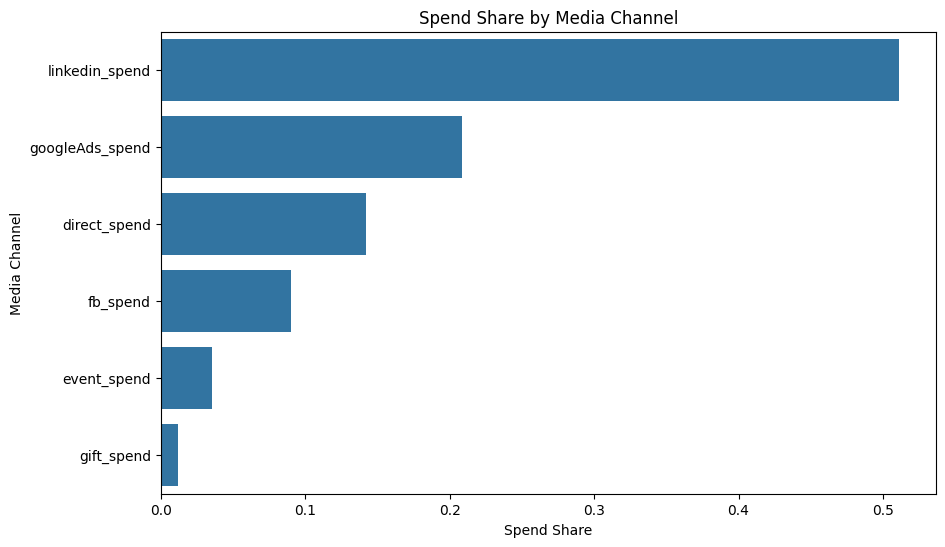


******** Correlation Analysis ********
Using revenue column: revenueProxy
Correlation of inputs with revenueProxy:
smoothed_MQL                 1.000000
mql_count                    0.750506
googleAds_spend              0.666414
gSearch_sessions             0.661128
impactDotCom_ga4_sessions    0.528749
linkedin_spend               0.316913
gift_spend                   0.297370
fb_spend                     0.168615
event_spend                  0.095848
email_opened_cnt             0.087296
daily_avg_queries            0.064415
daily_avg_queries            0.064415
podcast_streams              0.057639
direct_spend                 0.021080
durable_goods_rates         -0.012023
inflation_rate              -0.016332
t                           -0.159613
Name: revenueProxy, dtype: float64


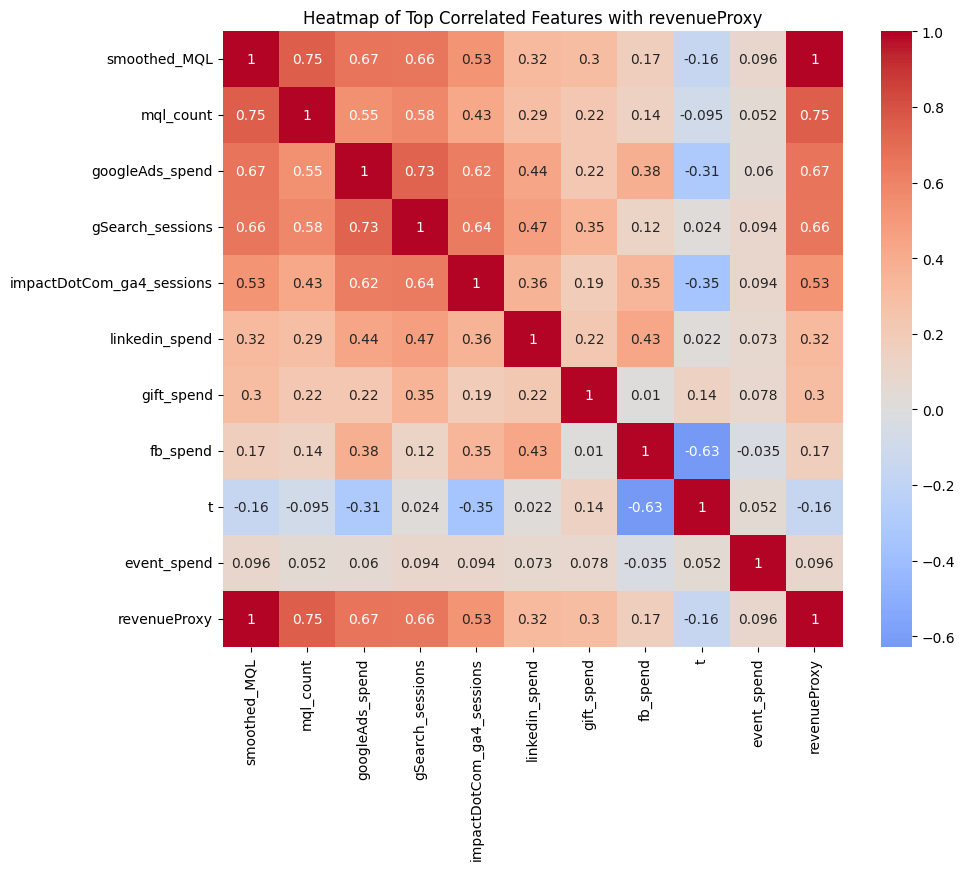


******** Multicollinearity Analysis ********
                      Feature         VIF
13          daily_avg_queries         inf
11          daily_avg_queries         inf
14             inflation_rate  106.541227
2            gSearch_sessions   38.986146
1              linkedin_spend   37.417070
10  impactDotCom_ga4_sessions   24.242475
7             googleAds_spend   22.382707
6                    fb_spend   20.885748
12               smoothed_MQL   14.650395
16                          t    7.935146
9                   mql_count    7.493651
3                  gift_spend    1.566889
0             podcast_streams    1.364188
15        durable_goods_rates    1.214029
4            email_opened_cnt    1.177828
5                direct_spend    1.064415
8                 event_spend    1.042971

******** Variables with Less Than 15 Records ********


/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [15]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                     for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [193]:
# Channel Mappings and Seasonality

In [16]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel



cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [17]:
def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
    """
    Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

    Parameters:
    - data (pd.DataFrame): The input dataframe.
    - date_column (str): The name of the date column.
    - output_variable (str): The name of the output variable.
    - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

    Returns:
    - pd.DataFrame: The dataframe with added seasonality features.
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Ensure the date column is in datetime format
    data[date_column] = pd.to_datetime(data[date_column])

    # Sort the data by date
    data = data.sort_values(by=date_column)

    # Set the date column as index for seasonal decomposition
    data.set_index(date_column, inplace=True)

    # Perform seasonal decomposition with multiplicative model
    decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

    # # Add seasonal component as a feature
    data[f'seasonal_{output_variable}'] = decomposition.seasonal
    # data[f'seasonal_{output_variable}'] = 1

    # Reset index to retain the date column
    data.reset_index(inplace=True)

    return data

# Example usage
data = create_seasonality_features(
    data,
    date_column='date_week',
    output_variable='mql_count',
    yearly_seasonality=52
)

data.head()

,date_week,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_spend,fb_spend,googleAds_spend,...,mql_count,impactDotCom_ga4_sessions,daily_avg_queries,smoothed_MQL,daily_avg_queries,inflation_rate,durable_goods_rates,revenueProxy,t,seasonal_mql_count
0,2024-04-11,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,9000.0,2169.57,6448.16,...,61,5091.0,24779.0,61.0,24779.0,0.0336,0.0022,61000.0,0,0.737777
1,2024-04-12,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,...,60,4936.0,24779.0,60.0,24779.0,0.0336,0.0022,60000.0,1,0.989168
2,2024-04-13,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,...,21,2708.0,24779.0,21.0,24779.0,0.0336,0.0022,21000.0,2,0.938033
3,2024-04-14,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,...,30,2665.0,24779.0,30.0,24779.0,0.0336,0.0022,30000.0,3,0.861381
4,2024-04-15,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,...,116,7681.0,24779.0,116.0,24779.0,0.0336,0.0022,116000.0,4,0.734026


In [18]:
data.columns

Index(['date_week', 'date', 'podcast_streams', 'linkedin_spend',
       'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 'direct_spend',
       'fb_spend', 'googleAds_spend', 'event_spend', 'mql_count',
       'impactDotCom_ga4_sessions', 'daily_avg_queries', 'smoothed_MQL',
       'daily_avg_queries', 'inflation_rate', 'durable_goods_rates',
       'revenueProxy', 't', 'seasonal_mql_count'],
      dtype='object')

In [19]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenueProxy',   # make sure this matches your KPI column in the DataFrame
    controls=['seasonal_mql_count', 'daily_avg_queries',
       'inflation_rate','durable_goods_rates'],  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:1033: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(


ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [143]:
data_meridian.as_dataset()

<xarray.Dataset> Size: 54kB
Dimensions:                (time: 335, geo: 1, control_variable: 1,
                            media_time: 335, media_channel: 6,
                            organic_media_channel: 3)
Coordinates:
  * time                   (time) object 3kB '2024-04-11' ... '2025-03-11'
  * geo                    (geo) <U12 48B 'national_geo'
  * control_variable       (control_variable) object 8B 'seasonal_mql_count'
  * media_time             (media_time) object 3kB '2024-04-11' ... '2025-03-11'
  * media_channel          (media_channel) <U15 360B 'linkedin_spend' ... 'ev...
  * organic_media_channel  (organic_media_channel) object 24B 'podcast_stream...
Data variables:
    kpi                    (geo, time) float64 3kB 6.1e+04 6e+04 ... 2.7e+04
    population             (geo) float64 8B 1.0
    controls               (geo, time, control_variable) float64 3kB 0.7378 ....
    revenue_per_kpi        (geo, time) float64 3kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    media                  (geo, media_time, media_channel) float64 16kB 1.10...
    media_spend            (geo, time, media_channel) float64 16kB 1.106e+04 ...
    organic_media          (geo, media_time, organic_media_channel) float64 8kB ...

In [161]:

build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=(0.51, 0.7),
  gift_spend=(0.10, 0.7),
  direct_spend=(0.13, 0.6),
  fb_spend=(0.09, 0.7),
  googleAds_spend=(0.20, 0.6),
  event_spend=(0.03, 0.5),
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [162]:
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912

Runtime: 125.2756 seconds


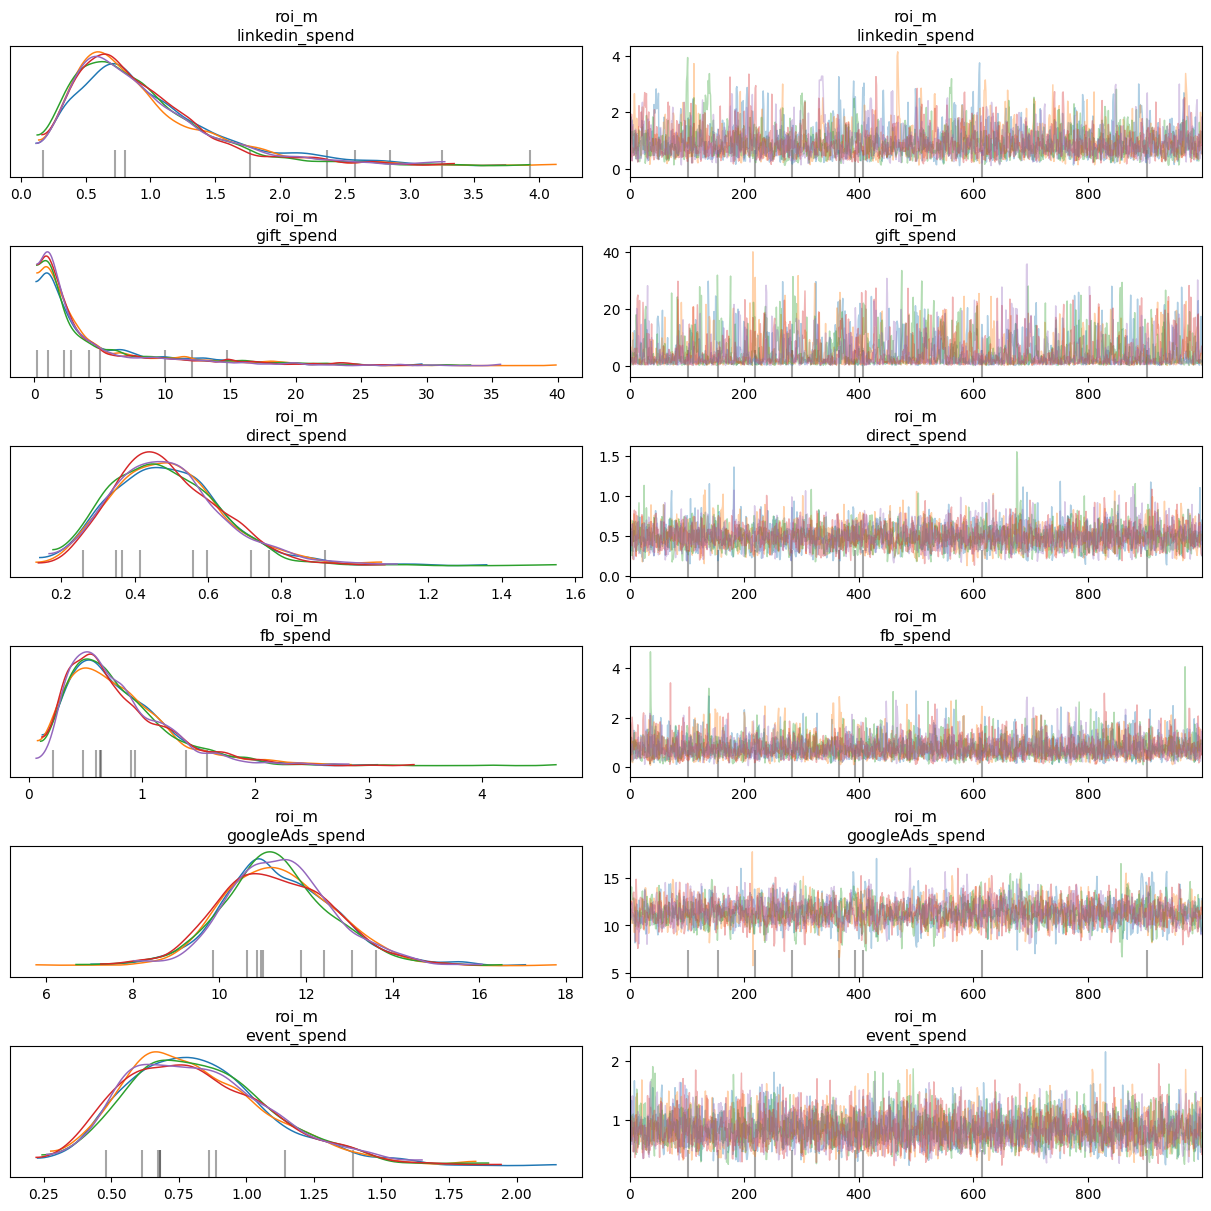

In [163]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [149]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [150]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [151]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()


/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:855: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$7,487,825 ($1,907,807, $18,728,074)","22.7% (5.8%, 56.8%)","1.9 (0.5, 4.9)","1.95 (0.50, 4.87)","0.9 (0.2, 2.5)","$0.7 ($0.2, $2.0)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$3,446,430 ($1,166,982, $7,516,269)","20.0% (6.8%, 43.7%)","0.9 (0.3, 2.0)","0.90 (0.30, 1.96)","0.3 (0.1, 0.6)","$1.3 ($0.5, $3.3)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$131,967 ($18,522, $355,227)","0.4% (0.1%, 1.1%)","1.5 (0.2, 4.0)","1.48 (0.21, 3.97)","0.7 (0.1, 1.9)","$1.0 ($0.3, $4.8)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$1,172,994 ($56,792, $2,558,768)","6.8% (0.3%, 14.9%)","13.1 (0.6, 28.6)","13.12 (0.64, 28.62)","5.6 (0.3, 11.9)","$0.1 ($0.0, $1.6)"
4,direct_spend,prior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$1,417,935 ($456,816, $3,101,216)","4.3% (1.4%, 9.4%)","1.3 (0.4, 2.9)","1.32 (0.43, 2.90)","0.7 (0.2, 1.5)","$0.9 ($0.3, $2.3)"
5,direct_spend,posterior,"1,070,271",14%,"$1,070,271",14%,"$1,000","$508,711 ($275,234, $798,167)","3.0% (1.6%, 4.6%)","0.5 (0.3, 0.7)","0.48 (0.26, 0.75)","0.2 (0.1, 0.3)","$2.2 ($1.3, $3.9)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$924,709 ($226,459, $2,368,931)","2.8% (0.7%, 7.2%)","1.4 (0.3, 3.5)","1.36 (0.33, 3.49)","0.6 (0.1, 1.8)","$1.0 ($0.3, $3.0)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$538,363 ($176,676, $1,141,916)","3.1% (1.0%, 6.6%)","0.8 (0.3, 1.7)","0.79 (0.26, 1.68)","0.4 (0.1, 0.8)","$1.4 ($0.6, $3.8)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$2,524,649 ($747,682, $6,341,452)","7.7% (2.3%, 19.2%)","1.6 (0.5, 4.0)","1.61 (0.48, 4.04)","0.8 (0.2, 2.0)","$0.8 ($0.2, $2.1)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$16,711,691 ($13,480,679, $20,232,706)","97.2% (78.4%, 117.7%)","10.7 (8.6, 12.9)","10.65 (8.59, 12.90)","6.6 (5.5, 7.7)","$0.1 ($0.1, $0.1)"


In [152]:

# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()


alt.LayerChart(...)

In [153]:
media_summary.plot_contribution_pie_chart()


alt.LayerChart(...)

In [154]:
media_summary.plot_spend_vs_contribution()


alt.FacetChart(...)

In [155]:
media_summary.plot_roi_bar_chart()


alt.LayerChart(...)

In [156]:
media_summary.plot_roi_vs_effectiveness()


alt.Chart(...)

In [157]:
media_summary.plot_roi_vs_mroi()


alt.Chart(...)

In [158]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

alt.FacetChart(...)

In [159]:
media_effects.plot_adstock_decay()


alt.FacetChart(...)

In [36]:
# Get last 4 weeks of data
last_4_weeks = data['date_week'][-4:].values

print("Last 4 weeks:")
for week in last_4_weeks:
    print(week)

# Calculate total media spend in last 4 weeks
last_4_weeks_spend = data[media].iloc[-4:]

print("\nTotal media spend in last 4 weeks:")
for week, spend in zip(last_4_weeks, last_4_weeks_spend):
    print(week,spend)

print(last_4_weeks_spend.sum().sum())

print(len(media))

Last 4 weeks:
2025-03-08T00:00:00.000000000
2025-03-09T00:00:00.000000000
2025-03-10T00:00:00.000000000
2025-03-11T00:00:00.000000000

Total media spend in last 4 weeks:
2025-03-08T00:00:00.000000000 linkedin_spend
2025-03-09T00:00:00.000000000 gift_spend
2025-03-10T00:00:00.000000000 direct_spend
2025-03-11T00:00:00.000000000 fb_spend
76929.76999999999
6


In [37]:
data


budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(
      selected_times=('2024-01-01', '2024-01-22'),
      budget=32733,
      spend_constraint_lower=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
      spend_constraint_upper=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
)

/var/folders/rt/jvrnppjd0lx_hpnwh05y501m0000gn/T/ipykernel_22955/1434568704.py:5: DeprecationWarning: `selected_times` is deprecated. Please use `start_date` and `end_date` instead.
  optimization_results = budget_optimizer.optimize(


ValueError: start_date (2024-01-01) must be in the time coordinates!

In [ ]:
optimization_results.nonoptimized_data

In [ ]:
optimization_results.optimized_data


In [ ]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()